# **Bitcoin EDA and Price Prediction**

![](http://image.hurimg.com/i/hurriyet/75/0x0/66ceda3a601c04688fba0897.jpg)

### **Data Description**
This is the Bitcoin Historical Dataset. The dataset provides information about historical price data for Bitcoin from January 1, 2018, to September 6, 2024.

Bitcoin Dataset: https://www.kaggle.com/datasets/novandraanugrah/bitcoin-historical-datasets-2018-2024

Dataset columns:
* Open time: First hour of 15 min.
* Open price: First price within 15 minutes
* High price: Highest price in 15 min.
* Low price: Lowest price in 15 mins
* Close price: Last price within 15 minutes
* Volume: If a total of $1 billion worth of buying and selling transactions took place in Bitcoin in one day, that is its trading volume.
* Close time: Last hour of 15 min.
* Quote asset volume: It refers to the total purchasing demand at a particular price level.
* Number of trades: It refers to the total number of transactions (buys, sales or transfers) made in a certain time period.
* Taker buy base asset volume: It means buying at the best bid price available at that moment.
* Taker buy quote asset volume: It refers to the total amount of assets that buyers are willing to purchase at a particular price level.
* Ignore: Some transactions or data entries may be "ignored" due to a bug or incompatibility in the Bitcoin software or a wallet application.

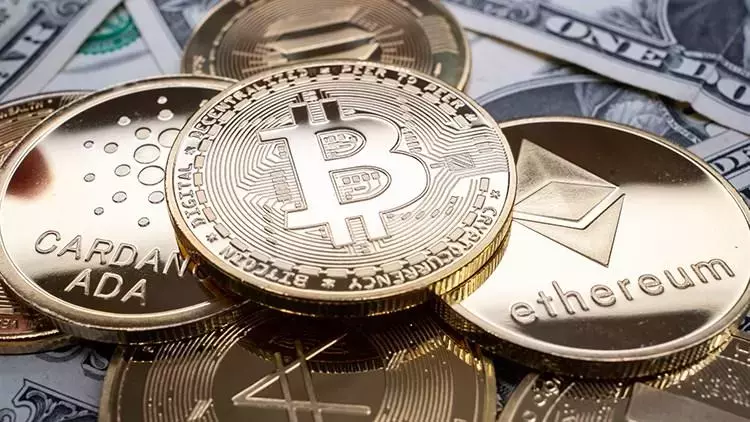
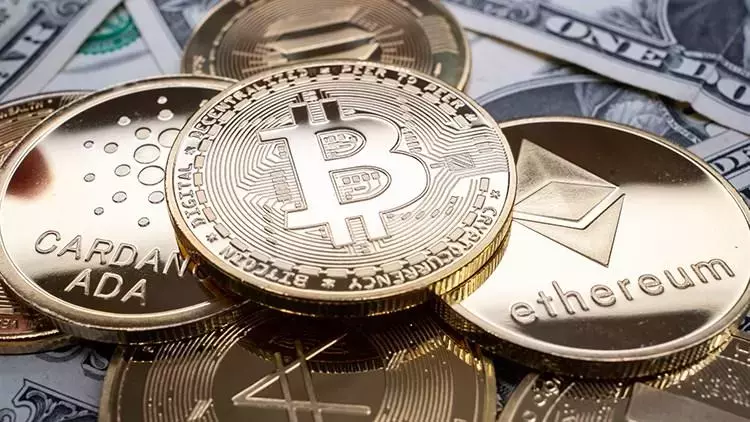

## 1. Dataset Review

In [2]:
# python libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ml libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# close warning library
import warnings
warnings.filterwarnings("ignore")

In [4]:
# read dataset
dataframe = pd.read_csv("/kaggle/input/bitcoin-historical-datasets-2018-2024/btc_15m_data_2018_to_2024-2024-10-10.csv")
df = dataframe.copy()

In [5]:
# create random missing values to dataset

import random

def add_random_missing_values(dataframe: pd.DataFrame,
                              missing_rate: float = 0.05,
                              seed: random = 42) -> pd.DataFrame:
    """Turns random values to NaN in a DataFrame.
    
    To use this function, you need to import pandas, numpy and random libraries.

    Args:
        dataframe (pd.DataFrame): DataFrame to be processed.
        missing_rate (float): Percentage of missing value rate in float format. Defaults 0.05

    
    """
    # Get copy of dataframe
    df_missing = dataframe.copy()

    # Obtain size of dataframe and number total number of missing values
    df_size = dataframe.size
    num_missing = int(df_size * missing_rate)

    # Set seed
    if seed:
       random.seed(seed)

    # Get random row and column indexes to turn them NaN
    for _ in range(num_missing):
        row_idx = random.randint(0, dataframe.shape[0] - 1)
        col_idx = random.randint(0, dataframe.shape[1] - 1)

        df_missing.iat[row_idx, col_idx] = np.nan
        
    return df_missing

df = add_random_missing_values(dataframe = df,
                               missing_rate = 0.03)

In [6]:
df.head()

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
0,2018-01-01 00:00:00,13715.65,13715.65,13400.01,13556.15,123.616013,2018-01-01 00:14:59.999,1.675545e+06,1572.0,63.227133,8.576108e+05,0.0
1,2018-01-01 00:15:00,13533.75,13550.87,13402.00,13521.12,98.136430,2018-01-01 00:29:59.999,1.321757e+06,1461.0,47.686389,6.422812e+05,NaN
2,2018-01-01 00:30:00,13500.00,13545.37,13450.00,13470.41,79.904037,2018-01-01 00:44:59.999,1.078825e+06,1000.0,43.710406,5.900347e+05,0.0
3,2018-01-01 00:45:00,13494.65,13690.87,13450.00,13529.01,141.699719,2018-01-01 00:59:59.999,1.917783e+06,1195.0,73.897993,1.000614e+06,0.0
4,2018-01-01 01:00:00,13528.99,13571.74,13402.28,13445.63,72.537533,2018-01-01 01:14:59.999,9.778198e+05,898.0,34.257652,4.618369e+05,0.0


In [7]:
df.tail()

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
236998,2024-10-10 06:30:00,61059.99,61105.00,61058.00,61064.86,113.84628,2024-10-10 06:44:59.999000,6.954123e+06,16250.0,56.61864,3.458480e+06,0.0
236999,2024-10-10 06:45:00,61064.86,NaN,61039.56,61143.85,190.04171,2024-10-10 06:59:59.999000,1.160895e+07,16920.0,81.78799,4.996370e+06,0.0
237000,2024-10-10 07:00:00,61143.86,61143.86,61079.44,61137.02,84.49996,2024-10-10 07:14:59.999000,5.163661e+06,10828.0,32.02905,1.957208e+06,0.0
237001,2024-10-10 07:15:00,61137.02,61145.99,NaN,61020.01,78.77599,2024-10-10 07:29:59.999000,4.811728e+06,18665.0,30.92458,1.888847e+06,0.0
237002,2024-10-10 07:30:00,61020.01,61020.01,60970.08,60984.00,67.63255,2024-10-10 07:44:59.999000,4.124782e+06,17272.0,24.77977,1.511192e+06,0.0


In [8]:
# show summary information about dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237003 entries, 0 to 237002
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Open time                     230010 non-null  object 
 1   Open                          229912 non-null  float64
 2   High                          229929 non-null  float64
 3   Low                           230119 non-null  float64
 4   Close                         230052 non-null  float64
 5   Volume                        230171 non-null  float64
 6   Close time                    229894 non-null  object 
 7   Quote asset volume            229950 non-null  float64
 8   Number of trades              229992 non-null  float64
 9   Taker buy base asset volume   229958 non-null  float64
 10  Taker buy quote asset volume  229951 non-null  float64
 11  Ignore                        229968 non-null  float64
dtypes: float64(10), object(2)
memory usage: 21.7

In [9]:
# show numbers of column and raw
df.shape

(237003, 12)

In [10]:
# give statistical summary information
df.describe()

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
count,229912.000000,229929.00000,230119.000000,230052.000000,230171.000000,2.299500e+05,229992.000000,229958.000000,2.299510e+05,229968.0
mean,26147.083614,26208.16769,26090.206350,26142.102163,759.903200,1.844562e+07,16460.240547,377.567168,9.131961e+06,0.0
std,19608.818336,19649.38735,19568.511726,19605.638781,1154.356213,2.859527e+07,24230.366955,573.864777,1.427018e+07,0.0
min,3166.110000,3174.78000,3156.260000,3167.070000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.0
25%,8826.185000,8846.23000,8801.000000,8827.142500,226.642950,3.066477e+06,3708.000000,112.081269,1.514107e+06,0.0
50%,20821.175000,20879.49000,20759.940000,20801.225000,398.254000,8.581460e+06,8337.000000,198.363351,4.138780e+06,0.0
75%,41171.197500,41254.69000,41079.480000,41156.145000,789.950462,2.261782e+07,17914.250000,393.894649,1.116919e+07,0.0
max,73607.800000,73777.00000,73400.000000,73607.800000,40371.405060,8.804418e+08,548344.000000,19925.616600,4.345161e+08,0.0


In [11]:
# choose column related to object datatype 

for col in df.select_dtypes(include='object').columns:
    print(col)
    print(df[col].unique())

Open time
['2018-01-01 00:00:00' '2018-01-01 00:15:00' '2018-01-01 00:30:00' ...
 '2024-10-10 07:00:00' '2024-10-10 07:15:00' '2024-10-10 07:30:00']
Close time
['2018-01-01 00:14:59.999' '2018-01-01 00:29:59.999'
 '2018-01-01 00:44:59.999' ... '2024-10-10 07:14:59.999000'
 '2024-10-10 07:29:59.999000' '2024-10-10 07:44:59.999000']


## 2. EDA(Explorarity Data Analysis)
* Find missing values
* Delete of Missing Value
* Find features with one value
* Explore the categorical features
* Find categorical feature distrubition
* Explore the numerical features
* Find discrete numerical features
* Find continuous numerical features
* Distrubition of continuous numerical features
* Relation between continuous numerical features and label
* Find outliers in numerical features
* Handling Outliers

## 2.1 Find missing values

In [12]:
# Find missing values
df. isnull().sum()

Open time                       6993
Open                            7091
High                            7074
Low                             6884
Close                           6951
Volume                          6832
Close time                      7109
Quote asset volume              7053
Number of trades                7011
Taker buy base asset volume     7045
Taker buy quote asset volume    7052
Ignore                          7035
dtype: int64

In [13]:
# find total missing values
df.isnull().sum().sum()

84130

In [14]:
# number of unmissing values
df.notnull().sum()

Open time                       230010
Open                            229912
High                            229929
Low                             230119
Close                           230052
Volume                          230171
Close time                      229894
Quote asset volume              229950
Number of trades                229992
Taker buy base asset volume     229958
Taker buy quote asset volume    229951
Ignore                          229968
dtype: int64

In [15]:
# total missing and unmissing values
print(f"There are a total of {df.notnull().sum().sum()} non-missing observations and, {df.isnull().sum().sum()} missing observations in the dataset.")

There are a total of 2759906 non-missing observations and, 84130 missing observations in the dataset.


In [16]:
# rows with at least 1 missing value
df[df.isnull().any(axis=1)]

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
1,2018-01-01 00:15:00,13533.75,13550.87,13402.00,13521.12,98.136430,2018-01-01 00:29:59.999,1.321757e+06,1461.0,47.686389,6.422812e+05,NaN
13,2018-01-01 03:15:00,13440.00,13611.27,13440.00,13562.37,112.273306,2018-01-01 03:29:59.999,1.516663e+06,1415.0,43.355251,NaN,0.0
15,2018-01-01 03:45:00,13510.00,13510.00,13400.04,NaN,113.174904,2018-01-01 03:59:59.999,1.522789e+06,1253.0,26.320066,3.540215e+05,0.0
24,2018-01-01 06:00:00,13539.00,13571.63,13510.00,13532.32,58.377845,2018-01-01 06:14:59.999,7.899298e+05,NaN,20.938556,2.833936e+05,0.0
25,2018-01-01 06:15:00,13532.00,13701.13,13510.51,13687.76,99.588918,2018-01-01 06:29:59.999,1.355583e+06,1275.0,NaN,8.124585e+05,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
236990,2024-10-10 04:30:00,60931.26,60940.00,60894.00,60916.16,76.899660,2024-10-10 04:44:59.999000,4.684497e+06,13603.0,NaN,2.058076e+06,0.0
236993,2024-10-10 05:15:00,60871.99,60886.00,60842.09,60886.00,NaN,2024-10-10 05:29:59.999000,3.942641e+06,11041.0,27.075410,1.647928e+06,0.0
236995,2024-10-10 05:45:00,60925.63,61052.00,60914.00,60941.48,149.856580,NaN,9.140537e+06,33882.0,73.669680,4.493868e+06,0.0
236999,2024-10-10 06:45:00,61064.86,NaN,61039.56,61143.85,190.041710,2024-10-10 06:59:59.999000,1.160895e+07,16920.0,81.787990,4.996370e+06,0.0


In [17]:
# rows with no missing values
df[df.notnull().all(axis=1)][:5]

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
0,2018-01-01 00:00:00,13715.65,13715.65,13400.01,13556.15,123.616013,2018-01-01 00:14:59.999,1.675545e+06,1572.0,63.227133,8.576108e+05,0.0
2,2018-01-01 00:30:00,13500.00,13545.37,13450.00,13470.41,79.904037,2018-01-01 00:44:59.999,1.078825e+06,1000.0,43.710406,5.900347e+05,0.0
3,2018-01-01 00:45:00,13494.65,13690.87,13450.00,13529.01,141.699719,2018-01-01 00:59:59.999,1.917783e+06,1195.0,73.897993,1.000614e+06,0.0
4,2018-01-01 01:00:00,13528.99,13571.74,13402.28,13445.63,72.537533,2018-01-01 01:14:59.999,9.778198e+05,898.0,34.257652,4.618369e+05,0.0
5,2018-01-01 01:15:00,13469.99,13595.89,13445.63,13560.00,87.861758,2018-01-01 01:29:59.999,1.189941e+06,939.0,45.135957,6.111437e+05,0.0


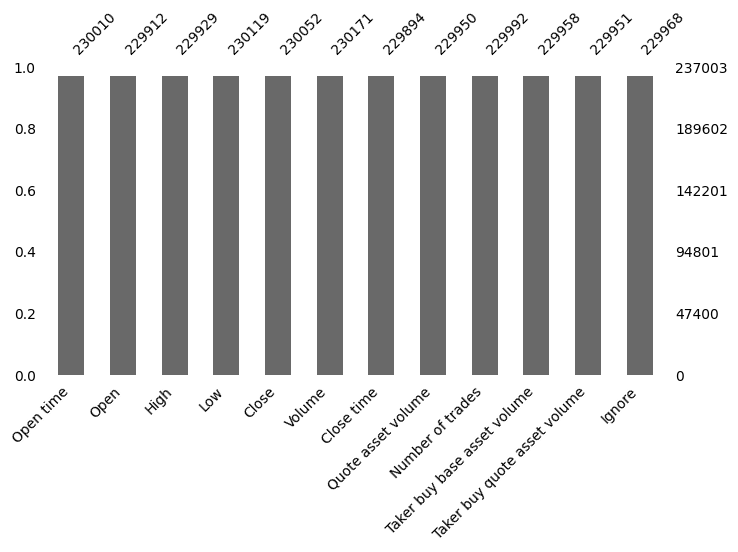

In [18]:
# visualization of missing values ​​by column
import missingno as msno # library that allows visualization of missing values ​​in a dataset

msno.bar(df = df,
         figsize = (8, 4),
         fontsize = 10);

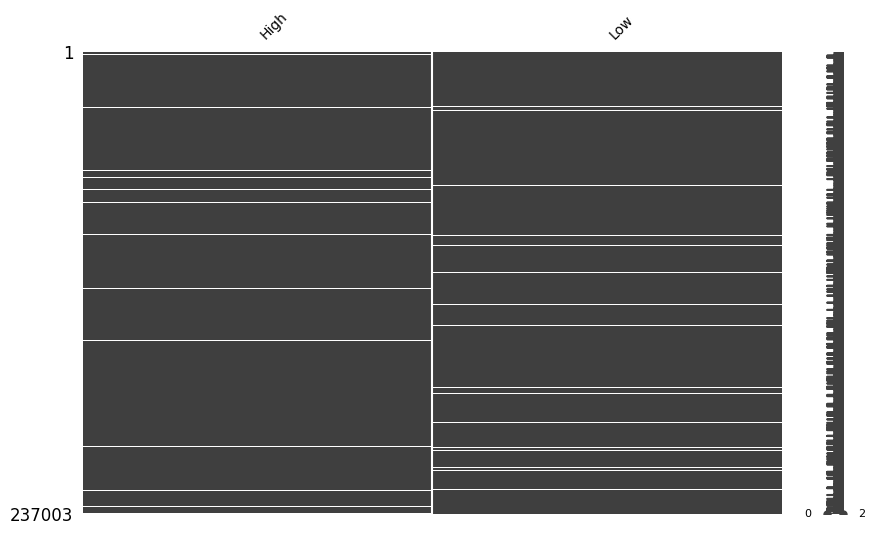

In [19]:
# Non-missing data are shown with solid lines, while missing data are shown with gaps.
msno.matrix(df = df[['High', 'Low']],
            figsize = (10,6),
            fontsize = 10);

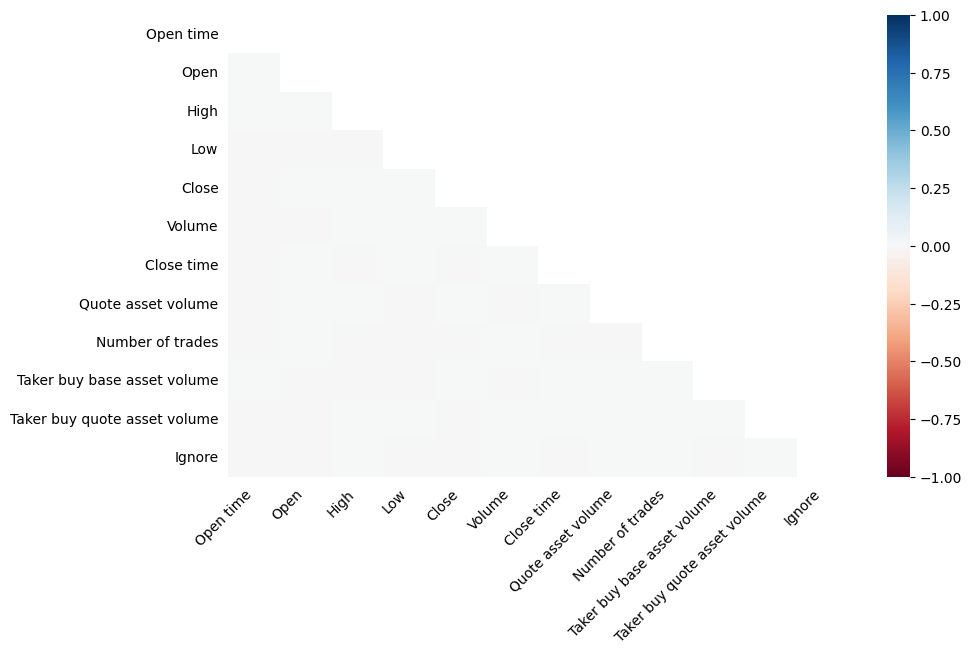

In [20]:
# a heat map showing how missing data is related across columns
# 1.0: Missing data are fully related
# 0.0: Missing data are completely unrelated.
msno.heatmap(df = df,
             figsize = (10,6),
             fontsize = 10);

## 2.2 Delete of missing values
I used the deletion method for missing data because overfitting may occur during the filling process.

In [21]:
df = df.dropna()
df.head()

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
0,2018-01-01 00:00:00,13715.65,13715.65,13400.01,13556.15,123.616013,2018-01-01 00:14:59.999,1.675545e+06,1572.0,63.227133,8.576108e+05,0.0
2,2018-01-01 00:30:00,13500.00,13545.37,13450.00,13470.41,79.904037,2018-01-01 00:44:59.999,1.078825e+06,1000.0,43.710406,5.900347e+05,0.0
3,2018-01-01 00:45:00,13494.65,13690.87,13450.00,13529.01,141.699719,2018-01-01 00:59:59.999,1.917783e+06,1195.0,73.897993,1.000614e+06,0.0
4,2018-01-01 01:00:00,13528.99,13571.74,13402.28,13445.63,72.537533,2018-01-01 01:14:59.999,9.778198e+05,898.0,34.257652,4.618369e+05,0.0
5,2018-01-01 01:15:00,13469.99,13595.89,13445.63,13560.00,87.861758,2018-01-01 01:29:59.999,1.189941e+06,939.0,45.135957,6.111437e+05,0.0


## 2.3 Find features with one value
Identifying and removing these columns when analyzing data speeds up the processing process and reduces unnecessary complexity.

In [22]:
# Finding single valued properties
single_value_features = [col for col in df.columns if df[col].nunique() == 1]
print(single_value_features)

['Ignore']


In [23]:
df = df.drop(columns=single_value_features)

In [24]:
df.head()

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
0,2018-01-01 00:00:00,13715.65,13715.65,13400.01,13556.15,123.616013,2018-01-01 00:14:59.999,1.675545e+06,1572.0,63.227133,8.576108e+05
2,2018-01-01 00:30:00,13500.00,13545.37,13450.00,13470.41,79.904037,2018-01-01 00:44:59.999,1.078825e+06,1000.0,43.710406,5.900347e+05
3,2018-01-01 00:45:00,13494.65,13690.87,13450.00,13529.01,141.699719,2018-01-01 00:59:59.999,1.917783e+06,1195.0,73.897993,1.000614e+06
4,2018-01-01 01:00:00,13528.99,13571.74,13402.28,13445.63,72.537533,2018-01-01 01:14:59.999,9.778198e+05,898.0,34.257652,4.618369e+05
5,2018-01-01 01:15:00,13469.99,13595.89,13445.63,13560.00,87.861758,2018-01-01 01:29:59.999,1.189941e+06,939.0,45.135957,6.111437e+05


## 2.4 Explore the Categorical Features

In [25]:
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'object']
categorical_features

['Open time', 'Close time']

In [26]:
for feature in categorical_features:
    num_categories = len(df[feature].unique())
    print('The feature is {} and number of categories are {}'.format(feature, num_categories))

The feature is Open time and number of categories are 165369
The feature is Close time and number of categories are 165369


## 2.5 Find Categorical Feature Distrubition

In [27]:
# To see the unique values ​​and frequencies of each categorical column
for feature in categorical_features:
    print(f"Distribution of '{feature}':")
    print(df[feature].value_counts())
    print("\n")

Distribution of 'Open time':
Open time
2018-01-01 00:00:00    1
2022-07-10 11:00:00    1
2022-07-10 18:00:00    1
2022-07-10 18:15:00    1
2022-07-10 18:30:00    1
                      ..
2020-04-08 00:30:00    1
2020-04-08 00:45:00    1
2020-04-08 01:00:00    1
2020-04-08 01:15:00    1
2024-10-10 07:30:00    1
Name: count, Length: 165369, dtype: int64


Distribution of 'Close time':
Close time
2018-01-01 00:14:59.999       1
2022-07-10 11:14:59.999       1
2022-07-10 18:14:59.999       1
2022-07-10 18:29:59.999       1
2022-07-10 18:44:59.999       1
                             ..
2020-04-08 00:44:59.999       1
2020-04-08 00:59:59.999       1
2020-04-08 01:14:59.999       1
2020-04-08 01:29:59.999       1
2024-10-10 07:44:59.999000    1
Name: count, Length: 165369, dtype: int64




In [28]:
# Percentage distribution
for feature in categorical_features:
    print(f"Percentage distribution of '{feature}':")
    print(df[feature].value_counts(normalize=True) * 100)
    print("\n")

Percentage distribution of 'Open time':
Open time
2018-01-01 00:00:00    0.000605
2022-07-10 11:00:00    0.000605
2022-07-10 18:00:00    0.000605
2022-07-10 18:15:00    0.000605
2022-07-10 18:30:00    0.000605
                         ...   
2020-04-08 00:30:00    0.000605
2020-04-08 00:45:00    0.000605
2020-04-08 01:00:00    0.000605
2020-04-08 01:15:00    0.000605
2024-10-10 07:30:00    0.000605
Name: proportion, Length: 165369, dtype: float64


Percentage distribution of 'Close time':
Close time
2018-01-01 00:14:59.999       0.000605
2022-07-10 11:14:59.999       0.000605
2022-07-10 18:14:59.999       0.000605
2022-07-10 18:29:59.999       0.000605
2022-07-10 18:44:59.999       0.000605
                                ...   
2020-04-08 00:44:59.999       0.000605
2020-04-08 00:59:59.999       0.000605
2020-04-08 01:14:59.999       0.000605
2020-04-08 01:29:59.999       0.000605
2024-10-10 07:44:59.999000    0.000605
Name: proportion, Length: 165369, dtype: float64




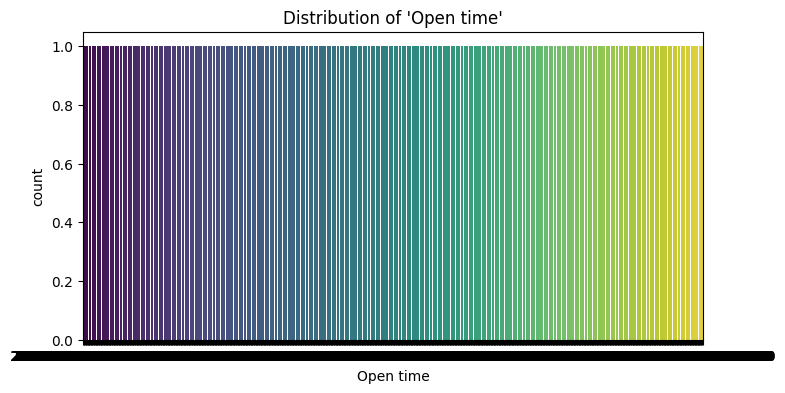

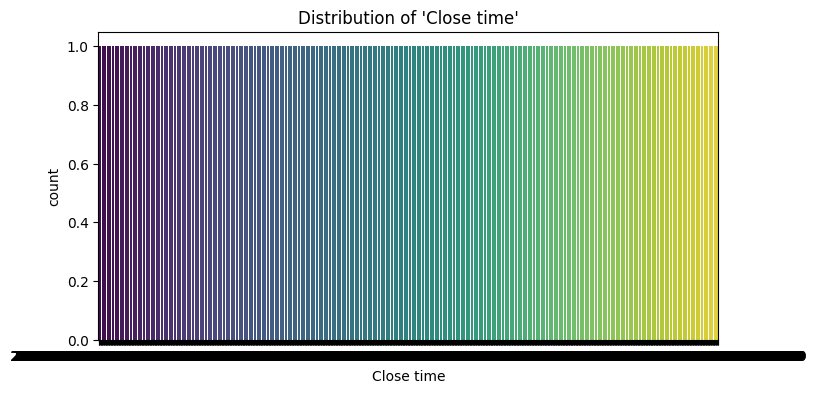

In [29]:
# Since the dataset was very large, I took 1000 random rows of categorical variables and visualized them.
subset_df = df.sample(1000)
for feature in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=subset_df, x=feature, palette='viridis')
    plt.title(f"Distribution of '{feature}'")
    plt.show()


## 2.6 Explore the Numerical Features

In [30]:
# Selects numeric properties other than the datatype object and the column named GLD and prints the number.
numerical_features = [feature for feature in df.columns if (df[feature].dtype != 'object')]
num_numerical_features = len(numerical_features)

print('Number of numerical variables:', num_numerical_features)
print(df[numerical_features].head())

Number of numerical variables: 9
       Open      High       Low     Close      Volume  Quote asset volume  \
0  13715.65  13715.65  13400.01  13556.15  123.616013        1.675545e+06   
2  13500.00  13545.37  13450.00  13470.41   79.904037        1.078825e+06   
3  13494.65  13690.87  13450.00  13529.01  141.699719        1.917783e+06   
4  13528.99  13571.74  13402.28  13445.63   72.537533        9.778198e+05   
5  13469.99  13595.89  13445.63  13560.00   87.861758        1.189941e+06   

   Number of trades  Taker buy base asset volume  Taker buy quote asset volume  
0            1572.0                    63.227133                  8.576108e+05  
2            1000.0                    43.710406                  5.900347e+05  
3            1195.0                    73.897993                  1.000614e+06  
4             898.0                    34.257652                  4.618369e+05  
5             939.0                    45.135957                  6.111437e+05  


## 2.7 Find Discrete Numerical Features

In [31]:
#  selects those with unique values less than 25 within numeric attributes
discrete_features = [feature for feature in numerical_features if len(df[feature].unique()) < 25]
num_discrete_features = len(discrete_features)

print(f"Discrete Variables Count: {num_discrete_features}")

Discrete Variables Count: 0


 ## 2.8 Find Continous Numerical Features

In [32]:
continuous_features = [feature for feature in numerical_features if feature not in discrete_features ]
num_continuous_features = len(continuous_features)

print(f"Continuous Feature Count: {num_continuous_features}")

Continuous Feature Count: 9


## 2.9 Distribution of Continous Numerical Features

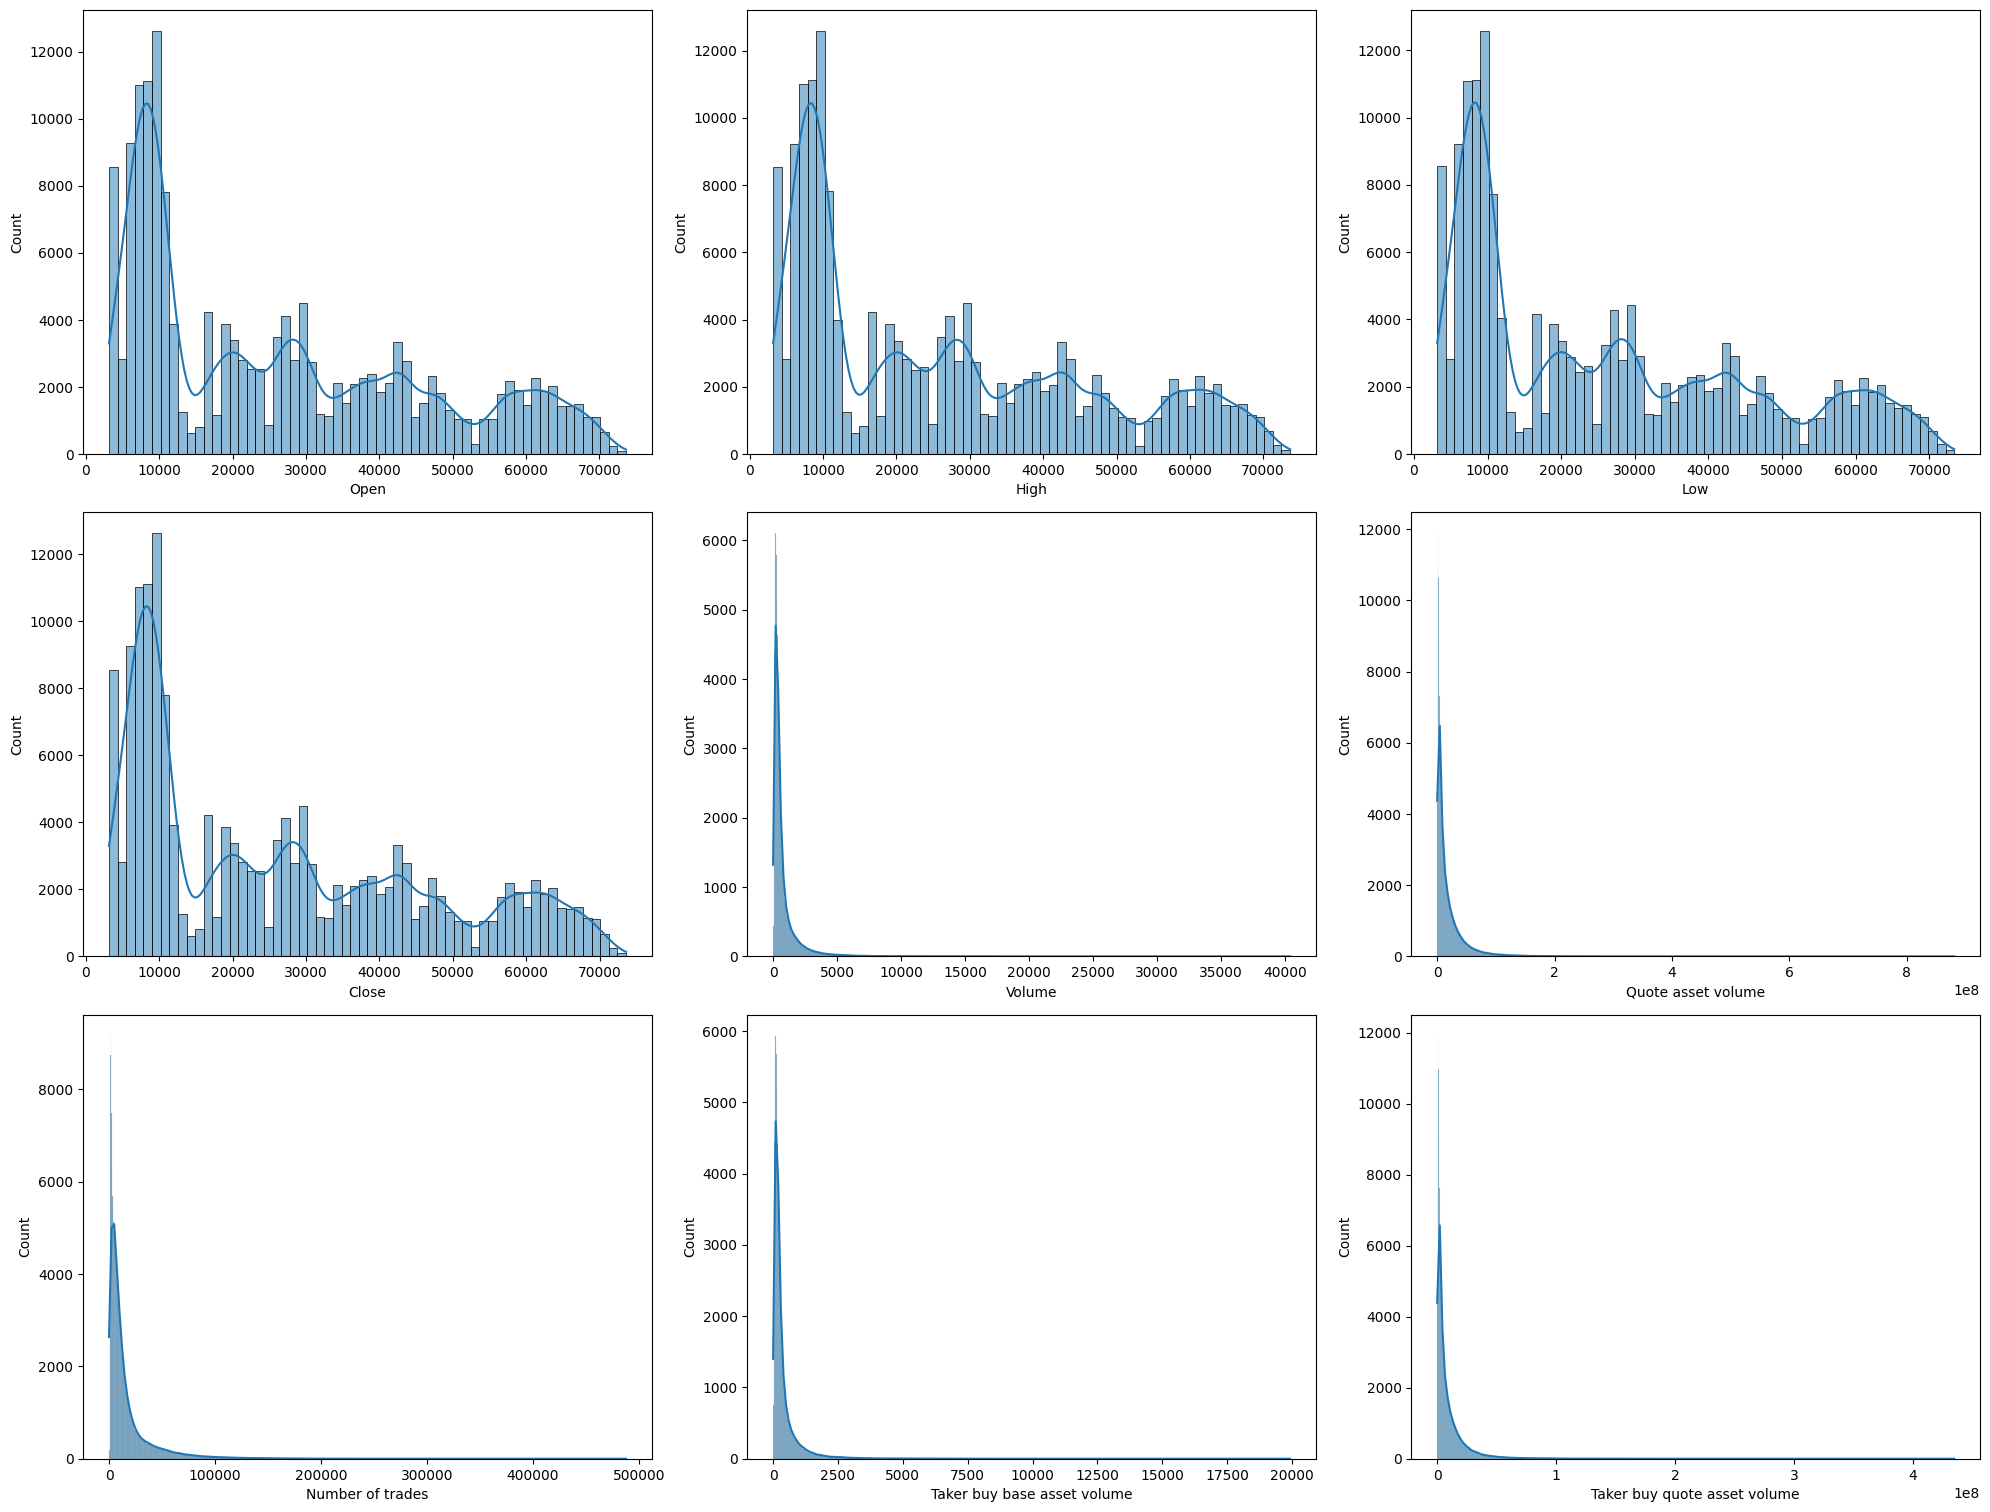

In [33]:
#  we plot histograms (frequency distribution plot) of the data

# We set the graphic to 20 by 60 with figsize and set the background color of the graphic to white with the facecolor argument.
plt.figure(figsize=(20, 60), facecolor='white')

for i, continuous_feature in enumerate(continuous_features, 1):
    # We create a subchart layout with 12 rows and 3 columns.
    plt.subplot(12, 3, i)
    # Here we create the histogram of the data. We ensure that the feature called continuous_feature is retrieved from the data 
    # frame. The kde=True argument causes a kernel density estimate to be plotted over the histogram.
    # This shows a smoother estimation of the data distribution.
    sns.histplot(df[continuous_feature], kde=True)
    # The feature name continuous_feature is used as the x-axis label.
    plt.xlabel(continuous_feature)

# It allows subgraphs to be placed in a tight order so that they are closer together and more readable.
plt.tight_layout()
plt.show()

## 2.10 Relation between Continuous numerical Features and Labels
To visualize the relationship between continuous features in the data frame and the "Close" feature, we create a series of scatter plots and display these plots in one large frame.

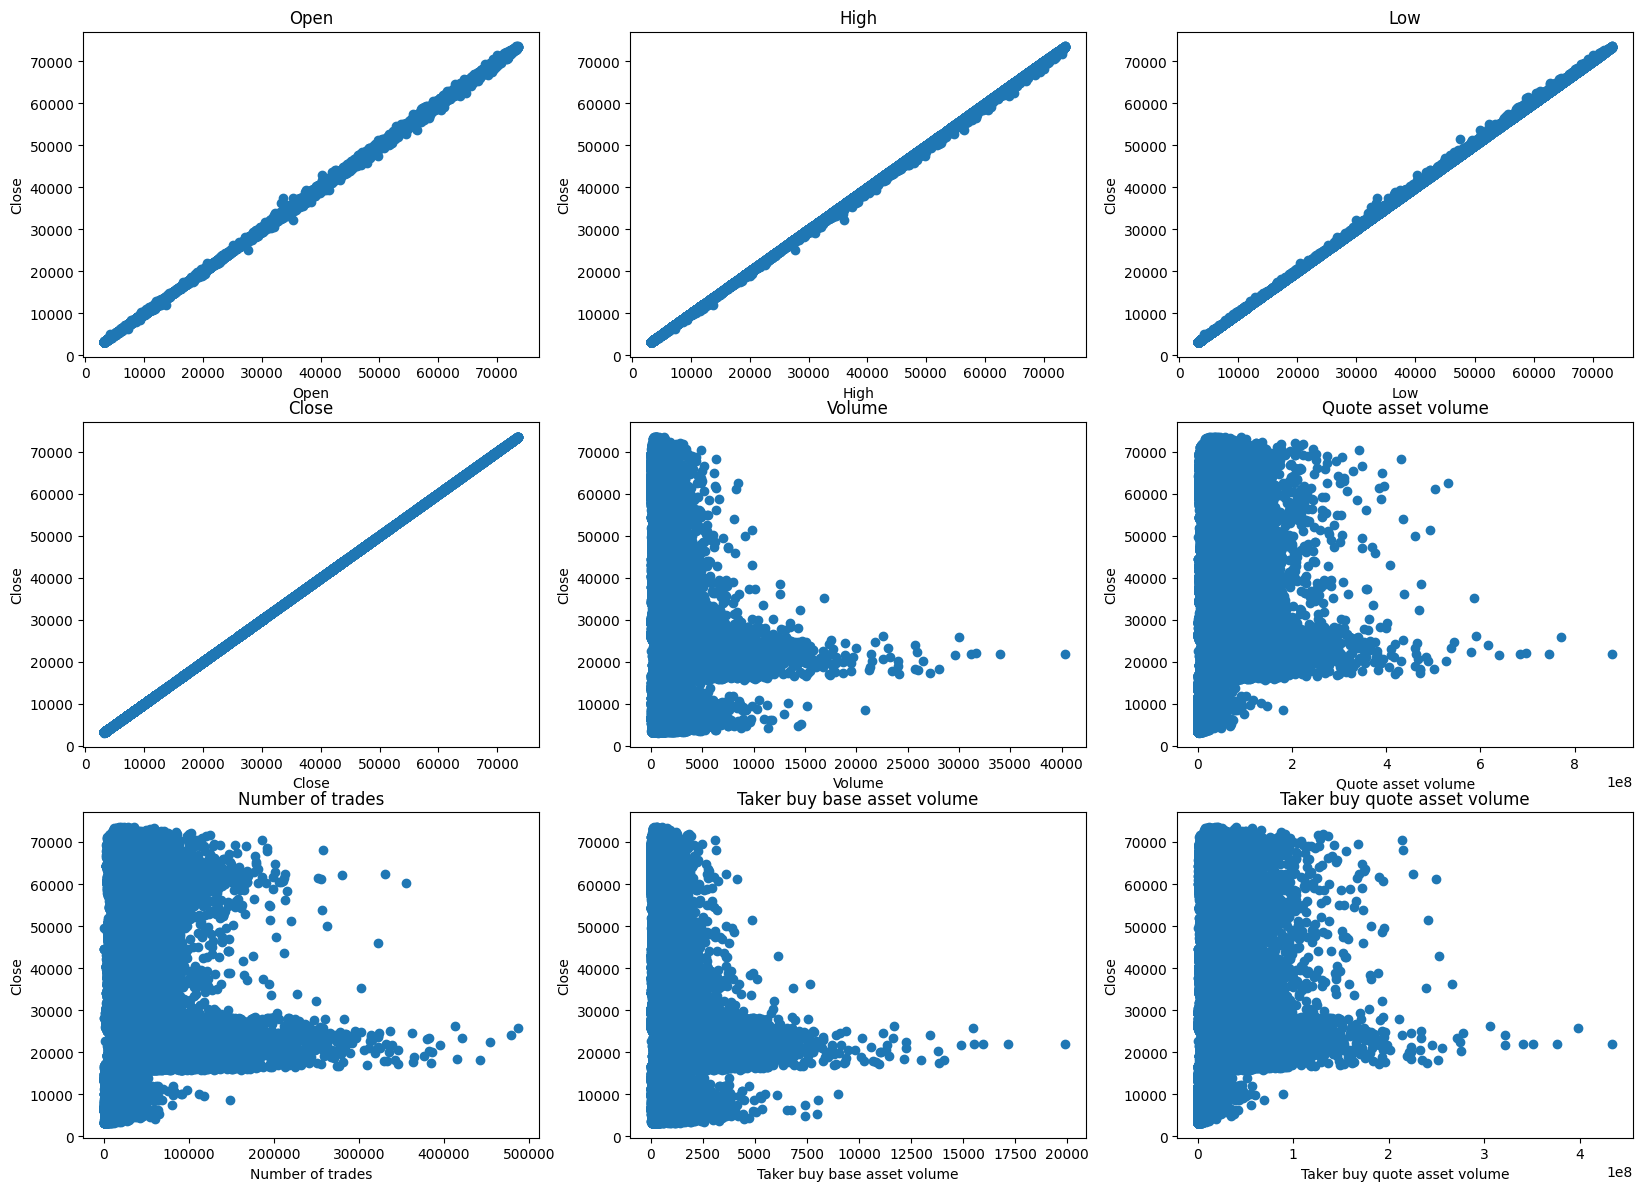

In [34]:
plt.figure(figsize=(20,60), facecolor = 'white')
# Represents the sequence number of subgraphs.
plotnumber = 1

for feature in continuous_features:
    data = df.copy()
    ax = plt.subplot(12,3,plotnumber)
    plt.scatter(data[feature], data['Close'])
    plt.xlabel(feature)
    plt.ylabel('Close')
    plt.title(feature)
    plotnumber += 1
plt.show()

## 2.11 Find Outliers in Numerical Features
It is clearly seen that there are a lot of outliers in the variables Volume, Quote Asset Volume, Number of Trades, Taker Buy Base Asset Volume and Taker Buy Quote Asset Volume. These outliers show that most of the data is concentrated in a small range but a few large values ​​are very far apart.

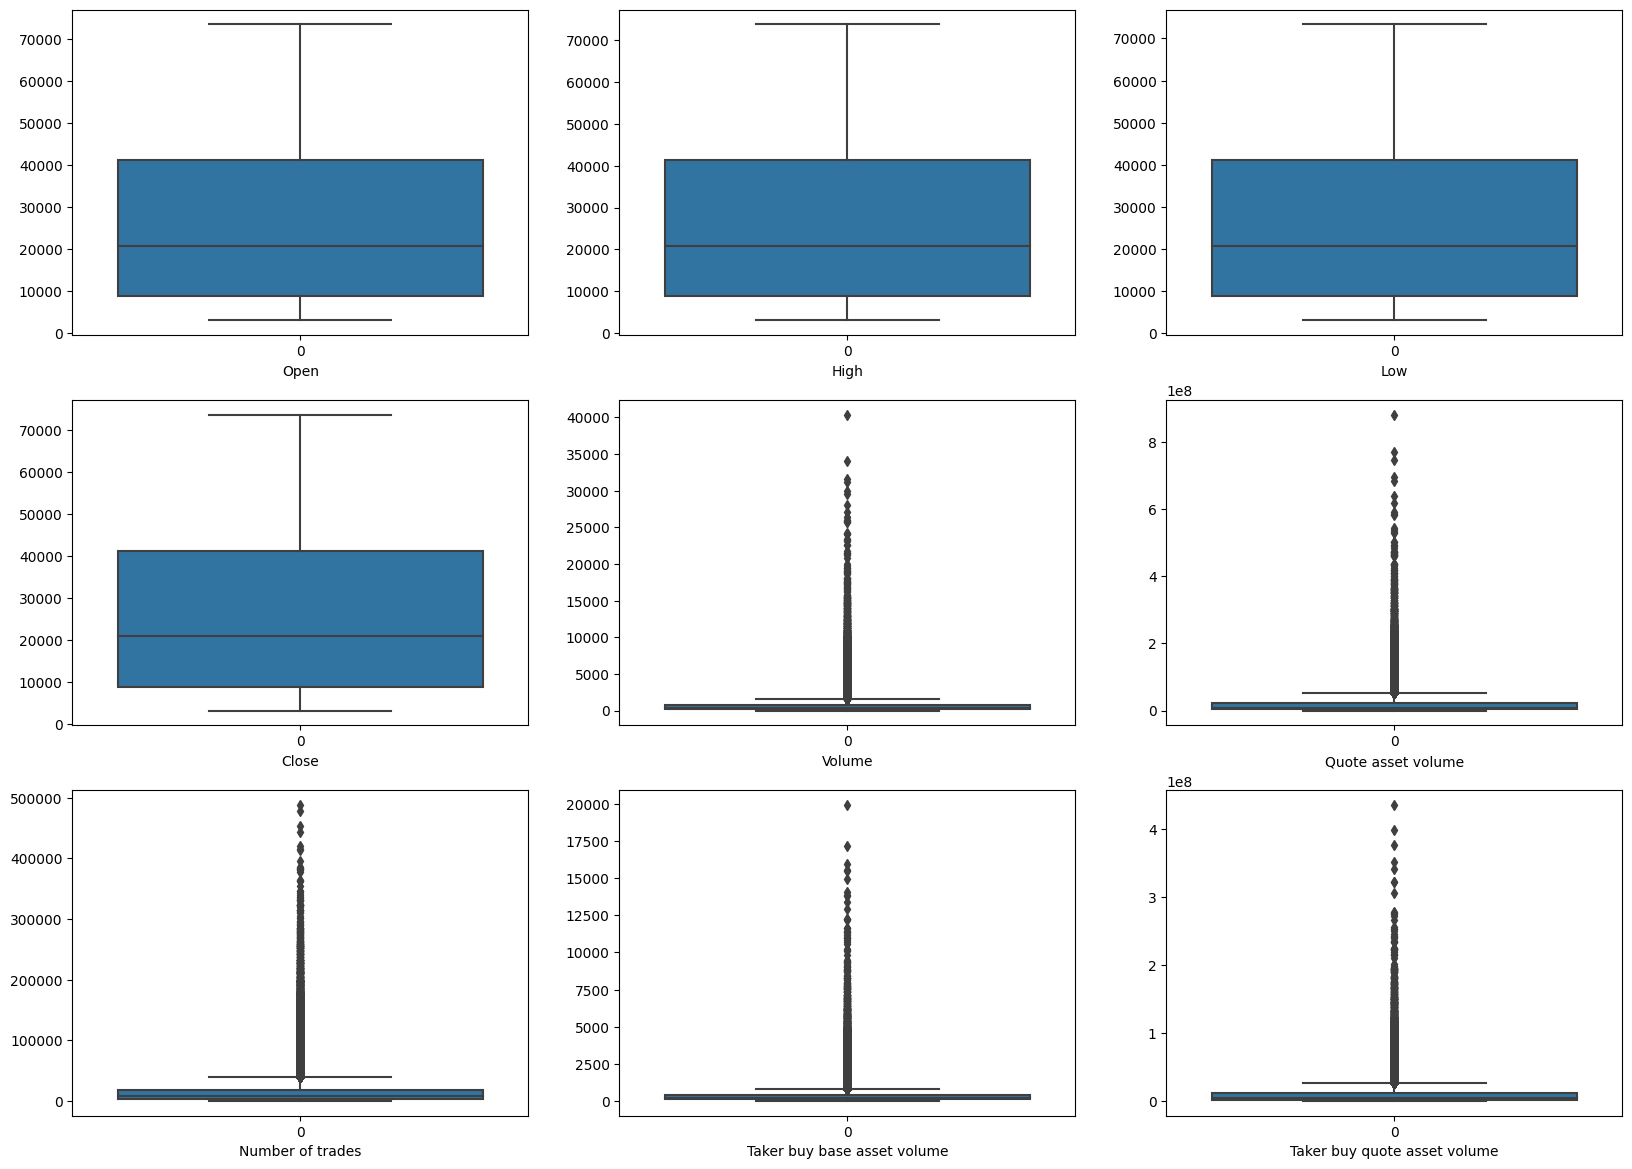

In [35]:
# boxplot on numerical features to find outliers
plt.figure(figsize=(20,60), facecolor = 'white')
plotnumber = 1

for numerical_feature in numerical_features:
    ax = plt.subplot(12,3,plotnumber)
    sns.boxplot(data[numerical_feature])
    plt.xlabel(numerical_feature)
    plotnumber += 1
plt.show()

## 2.12 Handling Outliers
1. Removal of Outliers (IQR):
Data points with extreme values ​​were removed from the data set.

2. Logarithmic Transformation:
The distribution of columns with dense value ranges was normalized. This transformation is widely used, especially in financial data with very large numerical values.

3. New Data Set:
The resulting data set will have a more regular distribution and model performance will increase.

In [36]:
# Variables to be processed
columns_to_check = ["Volume", "Quote asset volume", "Number of trades", 
                    "Taker buy base asset volume", "Taker buy quote asset volume"]

# Detection and removal of outliers using the IQR method
def remove_outliers_iqr(data, columns):
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Removing outliers
        data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
    return data

# Removing outliers
df_cleaned = remove_outliers_iqr(df, columns_to_check)

# Log transformation to reduce the impact of outliers
def apply_log_transformation(data, columns):
    for col in columns:
        data[col] = np.log1p(data[col])  # log(1+x) kullanımı, sıfır değerler için güvenlidir
    return data

# Applying log transformation
df_transformed = apply_log_transformation(df_cleaned, columns_to_check)

# Check the cleaned dataset
print(df_transformed.describe())
df = df_transformed

                Open           High            Low          Close  \
count  119036.000000  119036.000000  119036.000000  119036.000000   
mean    23973.737154   24011.645179   23932.327634   23971.853340   
std     19631.613278   19657.129799   19603.312678   19629.612295   
min      3166.110000    3174.780000    3156.260000    3167.070000   
25%      7955.122500    7974.200000    7932.937500    7954.990000   
50%     11753.585000   11775.280000   11727.650000   11752.765000   
75%     38721.665000   38789.590000   38646.195000   38717.185000   
max     73518.330000   73528.110000   73360.000000   73518.320000   

              Volume  Quote asset volume  Number of trades  \
count  119036.000000       119036.000000     119036.000000   
mean        5.652047           15.359157          8.532570   
std         0.634640            1.030454          0.823488   
min         0.000000            0.000000          0.000000   
25%         5.245138           14.631700          7.901748   
50%   

## 3. Future Engineering
* Calculating and visualizing averages of four different price types
* Visualizing Bitcoin price change percentage distribution
* Visualizing the density distribution of Bitcoin prices using Kernel Density Estimation (KDE)

## 3.1 Calculating and visualizing averages of four different price types

In [37]:
mean_close_price = df['Close'].mean()
mean_open_price = df['Open'].mean()
mean_high_price = df['High'].mean()
mean_low_price = df['Low'].mean()

mean_prices = pd.DataFrame({
    'Price Type': ['Close', 'Open', 'High', 'Low'],
    'Mean Price': [mean_close_price, mean_open_price, mean_high_price, mean_low_price]
})

mean_prices.style.background_gradient(cmap='Oranges')

,Price Type,Mean Price
0,Close,23971.853340
1,Open,23973.737154
2,High,24011.645179
3,Low,23932.327634


## 3.2 Visualizing Bitcoin price change percentage distribution

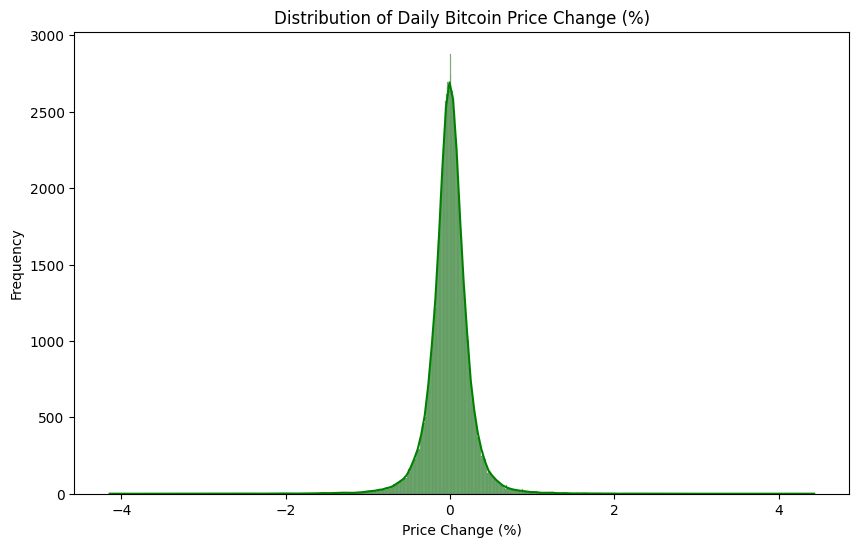

In [38]:
df['Price Change %'] = ((df['Close'] - df['Open']) / df['Open']) * 100
plt.figure(figsize=(10, 6))
sns.histplot(df['Price Change %'], kde=True, color='green')
plt.title('Distribution of Daily Bitcoin Price Change (%)')
plt.xlabel('Price Change (%)')
plt.ylabel('Frequency')
plt.show()

## 3.3 Visualizing the density distribution of Bitcoin prices using Kernel Density Estimation (KDE)

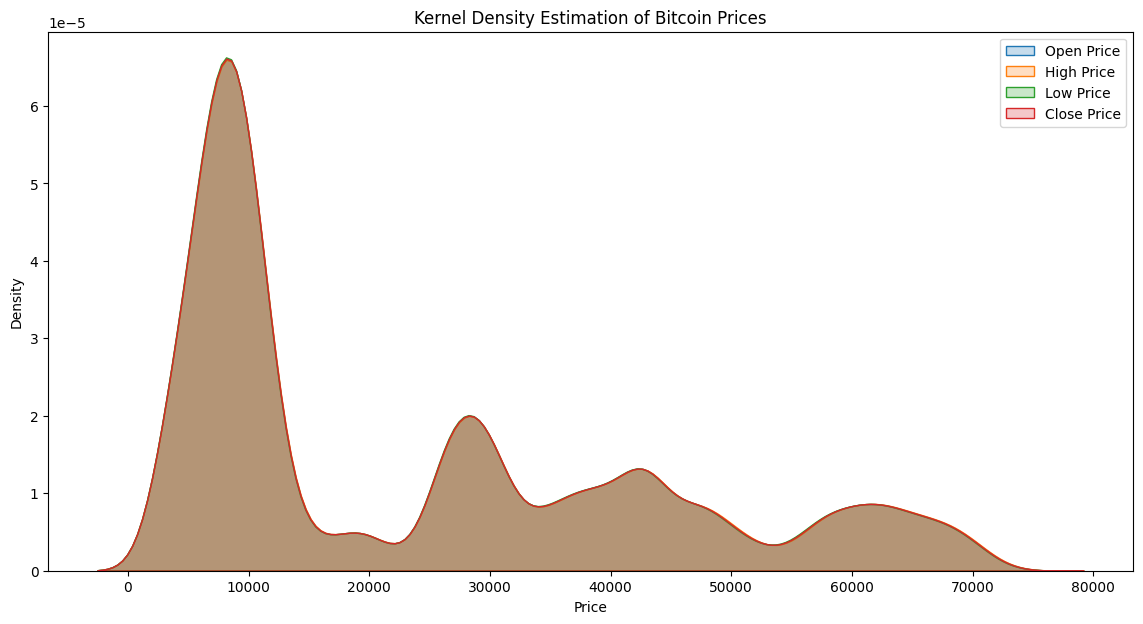

In [39]:
plt.figure(figsize=(14, 7))
sns.kdeplot(df['Open'], label='Open Price', shade=True)
sns.kdeplot(df['High'], label='High Price', shade=True)
sns.kdeplot(df['Low'], label='Low Price', shade=True)
sns.kdeplot(df['Close'], label='Close Price', shade=True)
plt.title('Kernel Density Estimation of Bitcoin Prices')
plt.xlabel('Price')
plt.ylabel('Density')
plt.legend()
plt.show()

## 4. Modeling
* Removing categorical variables from the model
* Split Dataset into Training set and Test set
* Model Selection

In [42]:
data_new = df.copy()

In [45]:
data_new.head()

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Price Change %
0,2018-01-01 00:00:00,13715.65,13715.65,13400.01,13556.15,4.825237,2018-01-01 00:14:59.999,14.331650,7.360740,4.162426,13.661907,-1.162905
2,2018-01-01 00:30:00,13500.00,13545.37,13450.00,13470.41,4.393264,2018-01-01 00:44:59.999,13.891384,6.908755,3.800206,13.287938,-0.219185
3,2018-01-01 00:45:00,13494.65,13690.87,13450.00,13529.01,4.960743,2018-01-01 00:59:59.999,14.466681,7.086738,4.316127,13.816126,0.254619
4,2018-01-01 01:00:00,13528.99,13571.74,13402.28,13445.63,4.297796,2018-01-01 01:14:59.999,13.793082,6.801283,3.562683,13.042969,-0.616158
5,2018-01-01 01:15:00,13469.99,13595.89,13445.63,13560.00,4.487082,2018-01-01 01:29:59.999,13.989415,6.845880,3.831593,13.323089,0.668226


## 4.1 Removing categorical variables from the model

In [47]:
data_new.drop(['Open time'], axis=1, inplace=True)
data_new.drop(['Close time'], axis=1, inplace=True)

## 4.2 Split Dataset into Training set and Test set


In [48]:
x = data_new.drop(['Close'], axis=1)
y = data_new['Close']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

## 4.3 Model Selection

In [50]:
# Decision Tree Regressor
tree_regression = DecisionTreeRegressor(random_state=42, max_depth=2) 
tree_regression.fit(x_train, y_train) 
predict_tree_regression = tree_regression.predict(x_test) 

# Random Foret Regressor
random_regression = RandomForestRegressor(n_estimators=100, max_depth=4, random_state=42) #number of trees=100
random_regression.fit(x_train, y_train)
predict_random_regression = random_regression.predict(x_test)


# Decision Tree Regressor
xgboost_regression = XGBRegressor(n_estimators=100, max_depth=2)
xgboost_regression.fit(x_train, y_train)
predict_xgboost_regression = xgboost_regression.predict(x_test)


predicts = [predict_tree_regression, predict_random_regression, predict_xgboost_regression ]
algorithm_names = ["Decision Tree Alg.", "Random Forest Alg.", "XGBoost Alg."]

def performance_calculate(predict): 
    mae = mean_absolute_error(y_test, predict)
    mse = mean_squared_error(y_test, predict)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predict)
    
    data = [mae, mse, rmse, r2]
    return data  


series  = []
metrics = ["Mean Absolute Error(MAE)", "Mean Squared Error(MSE)", "Root Mean Squared Error(RMSE)", "R2"]

for i in predicts:
    data = performance_calculate(i)
    series.append(data)
    
df = pd.DataFrame(data=series, index=algorithm_names, columns=metrics)
pd.set_option('display.colheader_justify', 'center')
print(df.to_string())

                    Mean Absolute Error(MAE)  Mean Squared Error(MSE)  Root Mean Squared Error(RMSE)     R2   
Decision Tree Alg.         2841.296501             1.383421e+07                 3719.436730           0.963565
Random Forest Alg.          704.330869             8.204449e+05                  905.784162           0.997839
XGBoost Alg.                280.522010             1.758050e+05                  419.291091           0.999537
